In [1]:
import pandas as pd
import numpy as np
import sqlite3
from pprint import pprint
%matplotlib inline
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import pygeohash as pgh
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
conn = sqlite3.connect("FPA_FOD_20170508.sqlite")

In [3]:
cursor = conn.cursor()
# get tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
pprint(cursor.fetchall())

[('spatial_ref_sys',),
 ('spatialite_history',),
 ('sqlite_sequence',),
 ('geometry_columns',),
 ('spatial_ref_sys_aux',),
 ('views_geometry_columns',),
 ('virts_geometry_columns',),
 ('geometry_columns_statistics',),
 ('views_geometry_columns_statistics',),
 ('virts_geometry_columns_statistics',),
 ('geometry_columns_field_infos',),
 ('views_geometry_columns_field_infos',),
 ('virts_geometry_columns_field_infos',),
 ('geometry_columns_time',),
 ('geometry_columns_auth',),
 ('views_geometry_columns_auth',),
 ('virts_geometry_columns_auth',),
 ('sql_statements_log',),
 ('SpatialIndex',),
 ('ElementaryGeometries',),
 ('KNN',),
 ('Fires',),
 ('idx_Fires_Shape',),
 ('idx_Fires_Shape_node',),
 ('idx_Fires_Shape_rowid',),
 ('idx_Fires_Shape_parent',),
 ('NWCG_UnitIDActive_20170109',)]


In [7]:
cursor.execute("SELECT DISTINCT(STAT_CAUSE_DESCR) FROM Fires")
print(cursor.fetchall())

[('Miscellaneous',), ('Lightning',), ('Debris Burning',), ('Campfire',), ('Equipment Use',), ('Arson',), ('Children',), ('Railroad',), ('Smoking',), ('Powerline',), ('Structure',), ('Fireworks',), ('Missing/Undefined',)]


In [8]:
df = pd.read_sql_query("SELECT * FROM Fires LIMIT 5;", conn)
df

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [10]:
df = pd.read_sql_query("SELECT * FROM NWCG_UnitIDActive_20170109 LIMIT 5;", conn)
df

,OBJECTID,UnitId,GeographicArea,Gacc,WildlandRole,UnitType,Department,Agency,Parent,Country,State,Code,Name
0,1,USAKCAN,AK,USAKACC,Resource Provider Only,Non-Government,NG,ANC,None,US,AK,CAN,Calista Regional Native Corporation
1,2,USAKCEKX,AK,USAKACC,Incident Host Geographic,US County/Local,AK,C&L,None,US,AK,CEKX,Central Emergency Services
2,3,USAKCFFX,AK,USAKACC,Incident Host Geographic,US County/Local,AK,C&L,None,US,AK,CFFX,City Fairbanks Fire Department
3,4,USAKCFMX,AK,USAKACC,Incident Host Geographic,US County/Local,AK,C&L,None,US,AK,CFMX,Central Mat-Su Fire Department
4,5,USAKCFQ,AK,USAKACC,Incident Host Geographic,US Federal,DOD,USAF,None,US,AK,CFQ,Clear Air Force Station


In [11]:
pprint(list(df.columns))

['OBJECTID',
 'UnitId',
 'GeographicArea',
 'Gacc',
 'WildlandRole',
 'UnitType',
 'Department',
 'Agency',
 'Parent',
 'Country',
 'State',
 'Code',
 'Name']


In [12]:
df = pd.read_sql_query("SELECT OBJECTID, LATITUDE, LONGITUDE, STAT_CAUSE_CODE, FIRE_SIZE, FIRE_YEAR FROM Fires;", conn)
df

,OBJECTID,LATITUDE,LONGITUDE,STAT_CAUSE_CODE,FIRE_SIZE,FIRE_YEAR
0,1,40.036944,-121.005833,9.0,0.10,2005
1,2,38.933056,-120.404444,1.0,0.25,2004
2,3,38.984167,-120.735556,5.0,0.10,2004
3,4,38.559167,-119.913333,1.0,0.10,2004
4,5,38.559167,-119.933056,1.0,0.10,2004
...,...,...,...,...,...,...
1880460,1880461,40.481637,-122.389375,13.0,0.01,2015
1880461,1880462,37.617619,-120.938570,9.0,0.20,2015
1880462,1880463,37.617619,-120.938570,13.0,0.10,2015
1880463,1880464,37.672235,-120.898356,13.0,2.00,2015


In [21]:
df = pd.read_sql_query("SELECT SUM(FIRE_SIZE) AS SUM_FIRE_SIZE, State FROM Fires GROUP BY State;", conn)
df = df.set_index("STATE")
df[:5]

,SUM_FIRE_SIZE
STATE,
AK,3.223309e+07
AL,9.205453e+05
AR,5.089118e+05
AZ,5.576681e+06
CA,1.274586e+07


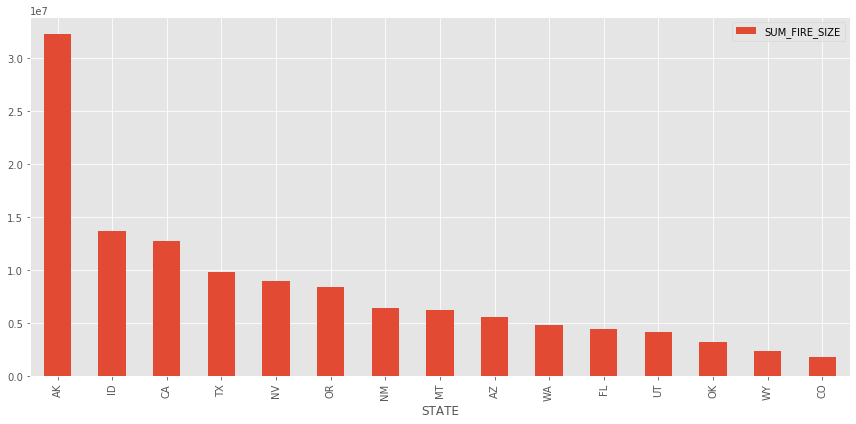

In [22]:
df.sort_values(by="SUM_FIRE_SIZE", ascending=False).iloc[:15].plot(kind="bar", **plot_options);
plt.tight_layout()
plt.savefig("figures/sum_fire_size_per_state.png")

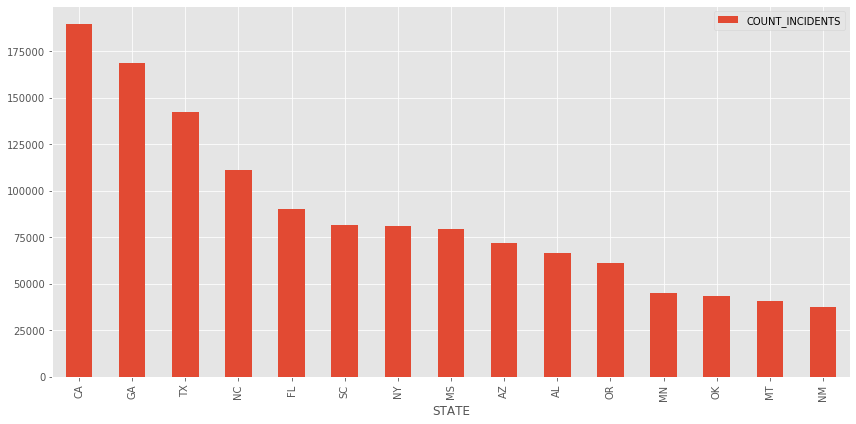

In [23]:
df = pd.read_sql_query("SELECT COUNT(OBJECTID) AS COUNT_INCIDENTS, State FROM Fires GROUP BY State;", conn)
df.set_index("STATE").sort_values(by="COUNT_INCIDENTS", ascending=False).iloc[:15].plot(kind="bar", **plot_options);
plt.tight_layout()
plt.savefig("figures/count_incidents_per_state.png")

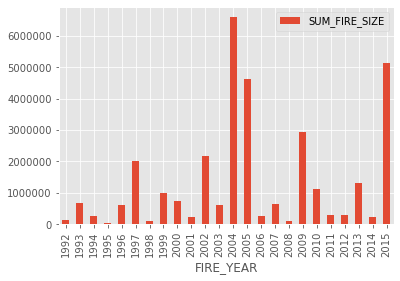

In [24]:
df = pd.read_sql_query("SELECT SUM(FIRE_SIZE) AS SUM_FIRE_SIZE, State, FIRE_YEAR FROM Fires WHERE State='AK' GROUP BY FIRE_YEAR;", conn)
df.set_index("FIRE_YEAR").plot(kind="bar");

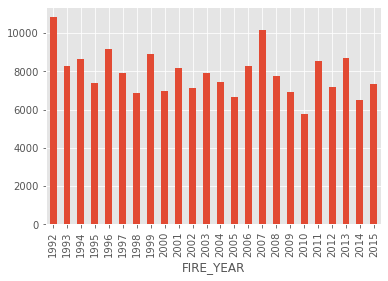

In [25]:
df = pd.read_sql_query("SELECT COUNT(OBJECTID) AS COUNT_INCIDENTS, State, FIRE_YEAR FROM Fires WHERE State='CA' GROUP BY FIRE_YEAR;", conn)
df.set_index("FIRE_YEAR")["COUNT_INCIDENTS"].plot(kind="bar");

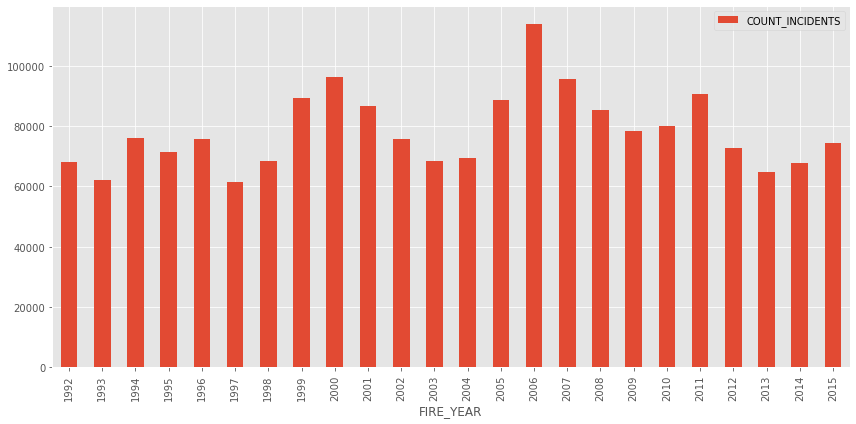

In [26]:
df = pd.read_sql_query("SELECT COUNT(OBJECTID) AS COUNT_INCIDENTS, FIRE_YEAR FROM Fires GROUP BY FIRE_YEAR;", conn)
df.set_index("FIRE_YEAR").plot(kind="bar", **plot_options);
#df.plot.scatter(x="FIRE_YEAR", y="COUNT_INCIDENTS");

plt.tight_layout()
plt.savefig("figures/count_incidents_over_years.png")

### Can we predict fire size 

In [37]:
def prepare_data(conn, columns, limit=None, geohash_precision=None, apply_log=None):

    
    if not "FIRE_SIZE" in columns:
        columns.append("FIRE_SIZE")
    
    columns_sql_string = ",".join(columns)
    
    limit_sql_string = ""
    if limit is not None:
        limit_sql_string = f"LIMIT {limit}"
        
    # In the current data version FIRE_SIZE is never NULL, however, since sqllite is dynamically typed, 
    # filtering does not hurt :). Same for minimum of DURATION_DAY.
    df = pd.read_sql_query(
        f"""
        SELECT {columns_sql_string} 
        FROM Fires JOIN NWCG_UnitIDActive_20170109 AS NWCG ON Fires.NWCG_REPORTING_UNIT_ID == NWCG.UnitId 
        WHERE FIRE_SIZE IS NOT NULL AND FIRE_SIZE > 0 AND DURATION_DAY > 0
        {limit_sql_string};
        """, 
        conn
    )
    
    if apply_log is not None:
        for column_name in apply_log:            
            df[column_name] = df[column_name].apply(np.log)
    
    X = df.drop(columns=["FIRE_SIZE"])
    y = df["FIRE_SIZE"]
    
    if geohash_precision is not None:
        create_geohash = lambda row: pgh.encode(row["LATITUDE"], row["LONGITUDE"], geohash_precision)
        X["GEOHASH"] = X[["LATITUDE", "LONGITUDE"]].apply(create_geohash, axis=1)
    
    # treat missing variables in numerical columns by imputing the mean
    # note, that int-typed columns can be categorical (e. g. STAT_CAUSE_CODE, but we take STAT_CAUSE_DESCR instead)
    X_numerical = X.select_dtypes(include=["float", "int"])
    fill_nan = lambda col: col.fillna(col.mean())
    X_numerical = X_numerical.apply(fill_nan)

    # prepare categorical columns
    X_categorical = X.select_dtypes(include=["object"])
    X_categorical = pd.get_dummies(X_categorical, dummy_na=False, drop_first=True)
    
    
    # Merge categorical and numerical
    X = pd.concat([X_numerical, X_categorical], axis=1)
    
    return X, y



In [38]:
def fit_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.02, random_state=42)
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)


    # Evaluate model performance r2_score

    # Predict 
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    # Score
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return dict(test_score=test_score, train_score=train_score)

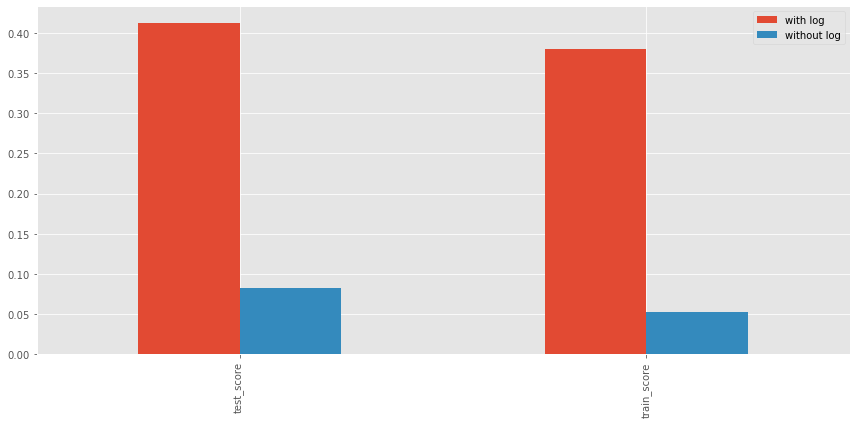

In [39]:
# without log
X, y = prepare_data(
    conn, 
    columns,
    limit=4e5,
    geohash_precision=2
)
scores_without_log = fit_model(X, y)

# with log
X_log, y_log = prepare_data(
    conn, 
    columns + [ 
        """
        (
          CONT_DATE - DISCOVERY_DATE + (
            ((CONT_TIME % 100)/60.0 + CONT_TIME / 100)/24
          ) - (
            ((DISCOVERY_TIME % 100)/60.0 + DISCOVERY_TIME / 100)/24
          )
        ) AS DURATION_COMBINED_LOG
        """
    ],
    limit=4e5,
    geohash_precision=2,
    apply_log=["FIRE_SIZE", "DURATION_COMBINED_LOG"]
)

scores_with_log = fit_model(X_log, y_log)

df = pd.DataFrame.from_records([scores_with_log, scores_without_log], index=["with log", "without log"])
df.T.plot.bar(**plot_options);

plt.tight_layout()
plt.savefig("figures/comparision_with_without_log.png")